# Image Segmentation with K-Means

## 1. Prepare

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
import cv2
import random
import time
from skimage import color
from skimage import segmentation

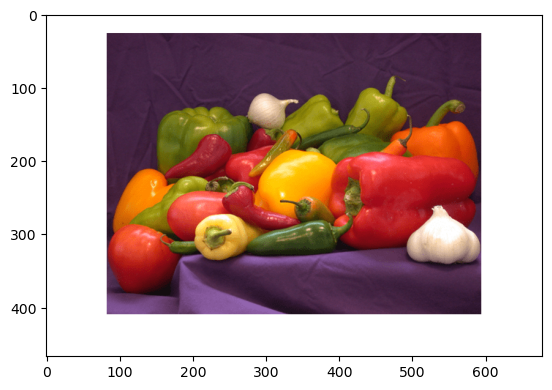

In [13]:
source_img = plt.imread("Image Segmentation/peppers.png")[:,:,:3]
plt.imshow(source_img)
plt.show()

In [18]:
def img_to_data(path):
    img = cv2.imread(path)
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    n, d, _ = img.shape
    X = img.reshape((n*d, -1)).astype('int')
    return X, img

In [29]:
img_path = "Image Segmentation/peppers.png"
X, img = img_to_data(img_path)
pd.DataFrame(X)

,0,1,2
0,255,128,128
1,255,128,128
2,255,128,128
3,255,128,128
4,255,128,128
...,...,...,...
316621,255,128,128
316622,255,128,128
316623,255,128,128
316624,255,128,128


## 2. Build Model

In [10]:
def kmeansp(data,k=7):
    
    # Step 1: Choosing random points to be clusters
    depth = 3
    k = 7
    # centroids = np.zeros((7,depth))
    centroids =data[random.sample(range(data.shape[0]), 1)]
    print(data.shape)
    for i in range(k-1):
        distances = distance(data.reshape(-1,1,depth),centroids.reshape(1,-1,depth))
        # find closest centroids for each poitn
        labels = np.argmin(distances,axis=1)
        total_distance = 0
        current_prob = []
        for i in range(labels.shape[0]):
            # distance from this point to the nearest centroid / total distance
#             print(centroids.shape)
#             print(labels[i])
            current_distance = np.sum((data[i].reshape(-1,depth)-centroids[labels[i],:])**2)
            total_distance = total_distance + current_distance

        for i in range(labels.shape[0]):
            # distance from this point to the nearest centroid / total distance
            current_prob.append(np.sum((data[i].reshape(-1,depth)-centroids[labels[i],:])**2)/total_distance)
        centroid_new = data[np.argmax(current_prob)]
        # update centroid
        centroids = np.vstack((centroids.reshape(-1,depth),centroid_new))
    centroids = centroids.reshape(1,k,-1)
    start = time.time()
    data = data.reshape(-1,1,depth)
    # creating an array to store labels
    labels = np.zeros(len(data),dtype=np.float32)
    previous_labels = np.zeros(len(data))
    comparison = np.zeros(len(data),dtype='bool')
    i = 0;
    while(comparison.all() != True):
        # if exceed 200 iterations break the loop
        if (i>200):
            break
        # Step 2: Assigning each point to its closest centroid
        # calculating distance
        distances = distance(data,centroids)
        print(distances.shape)
        # find closest centroids for each poitn
        previous_labels = labels.copy()
        labels = np.argmin(distances,axis=1)
        #Step 3: updating centroids
        for center in range(k):
            centroids[0,center,:] = np.mean(data[labels==center].reshape(-1,depth),axis=0)

        # compare to see if no new points are reassigned => if the centroids are not updated
        comparison = (labels == previous_labels)
        i = i+1
    stop = time.time()
    print(stop-start)
    return centroids,labels

def distance(x, centroid):
    # Compute the difference, following by raising to power 2 and summing
    dist = ((x - centroid) ** 2).sum(axis = 2)   # change of axis
    return dist

In [11]:
start = time.time()
centroids , labels = kmeansp(X,13)
stop = time.time()
# flatten the labels array
labels = labels.flatten()
segmented_image = centroids[0,labels.flatten()]

(316626, 3)
(316626, 7)
(316626, 7)
(316626, 7)
(316626, 7)
(316626, 7)
(316626, 7)
(316626, 7)
(316626, 7)
(316626, 7)
(316626, 7)
(316626, 7)
(316626, 7)
0.8462162017822266


In [12]:
labels = labels.reshape(467,678)

In [55]:
kmeans_img = color.label2rgb(labels, source_img) # color each pixel according to its label

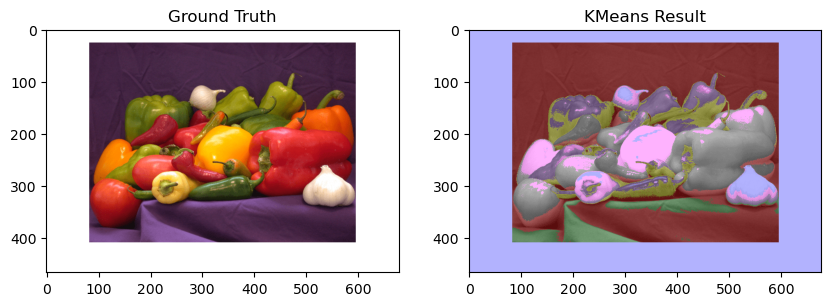

In [56]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title("Ground Truth")
plt.imshow(source_img)
plt.subplot(122)
plt.title("KMeans Result")
plt.imshow(kmeans_img)
plt.show()

# Image Segmentation with GMM

## 1. Prepare

In [32]:
# Read the image
image = cv2.imread(img_path)

# Flatten the image to a 1D array
pixels = image.reshape((-1, 3))
pd.DataFrame(pixels)

,0,1,2
0,255,255,255
1,255,255,255
2,255,255,255
3,255,255,255
4,255,255,255
...,...,...,...
316621,255,255,255
316622,255,255,255
316623,255,255,255
316624,255,255,255


In [17]:
input_image_path = "Image Segmentation/peppers.png"
segmented_image = image_segmentation_gmm(input_image_path, n_components=4)
cv2.imshow("Segmented Image", segmented_image)

## 2. Build Model

In [33]:
from sklearn.mixture import GaussianMixture

In [76]:
def image_segmentation_gmm(pixels, n_components=2):
    # Initialize the Gaussian Mixture Model
    model = GaussianMixture(n_components=n_components, max_iter=200, random_state=42)

    # Fit the GMM to the data (pixel intensities)
    model.fit(pixels)

    # Predict the segment for each pixel
    segment_labels = model.predict(pixels)

    # Reshape the labels to the original image shape
    segment_labels = segment_labels.reshape(image.shape[0], image.shape[1])

    # Color each pixel according to its label
    segmented_image = color.label2rgb(segment_labels, source_img) 
    
    return segmented_image

In [77]:
segmented_image = image_segmentation_gmm(pixels, 13)

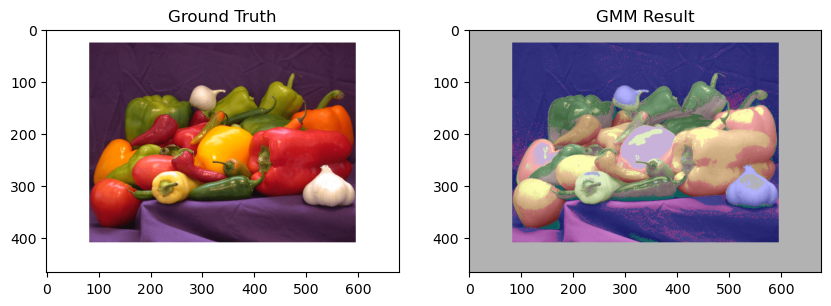

In [78]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title("Ground Truth")
plt.imshow(source_img)
plt.subplot(122)
plt.title("GMM Result")
plt.imshow(segmented_image)
plt.show()

# Evaluate

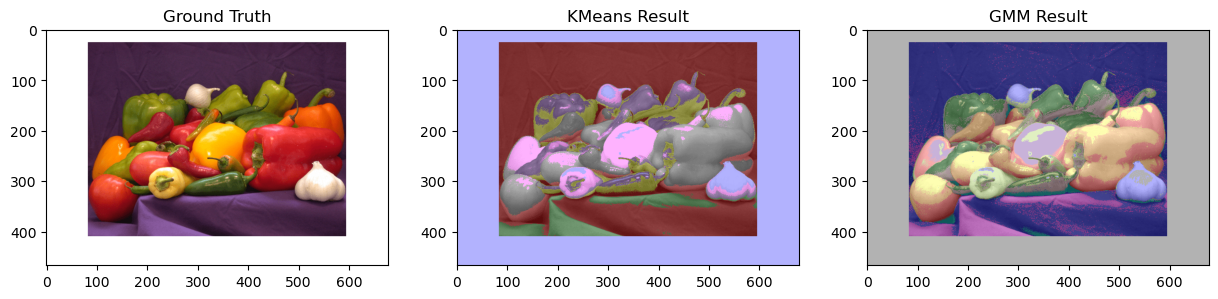

In [79]:
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.title("Ground Truth")
plt.imshow(source_img)
plt.subplot(132)
plt.title("KMeans Result")
plt.imshow(kmeans_img)
plt.subplot(133)
plt.title("GMM Result")
plt.imshow(segmented_image)
plt.show()

**NOTE: Cả hai phương pháp đều cho ra ảnh segment tương đối chính xác. Tuy nhiên phương pháp GMM cho ra kết quả rõ ràng hơn, phân biệt cụ thể các chủ thể có màu gần giống nhau trong ảnh gốc**